# Dataset: Trackster neighborhood with PU

- select a trackster having at least 50% of the simtrackster energy (0.5 from the associator) and energy above 10GeV
- connect its barycenter to (0,0,0), that gives the trackster axis
- draw a cylinder along this axis, 10cm wide, going 3 layers (or 10cm) before and after the first/last layer-cluster
- connect to all tracksters with a barycenter within this cone (star-like labels)
- labels based on the associator score (can even be binary)
- start with photons, 90% of them are fine, we just wanna fix the remaining 10%
- if we are doing well here, we can go to pions which are much more fragmented
- cut off at 0.2 but can include events with no edges too

Physics evaluation
- plug it into the CMSSW

Method evaluation
- based on precision and recall
    - precision: 2 LC from RECO (within the cone?) also together in SIM
        - how much mess I got in?
    - recall: 2 LC from SIM together in RECO
        - how good did I do on the connecting?


In [1]:
import numpy as np
import awkward as ak

from matplotlib.ticker import FormatStrFormatter

from reco.datasetPU import get_event_pairs
from reco.data import get_bary_data, get_event_data, clusters_by_indices, FEATURE_KEYS
from reco.features import get_min_max_z_points
from reco.plotting import plot_sim_reco

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "CloseByGamma200PUFull"
file_name = "new_ntuples_15410634_1.root"

# ds_name = "SinglePion200PU"
# file_name = "new_ntuples_15455079_1.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"


In [2]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

In [3]:
for eid in range(10):
    sc = simtrackster_data["stsSC_raw_energy"][eid]
    print(len(sc))

1
1
1
1
1
1
1
1
1
1


[1915, 2247, 2304, 2306, 2426, 2462, 2497, 2498, 2522, 2523, 2564, 2670, 2728, 2730, 2811]


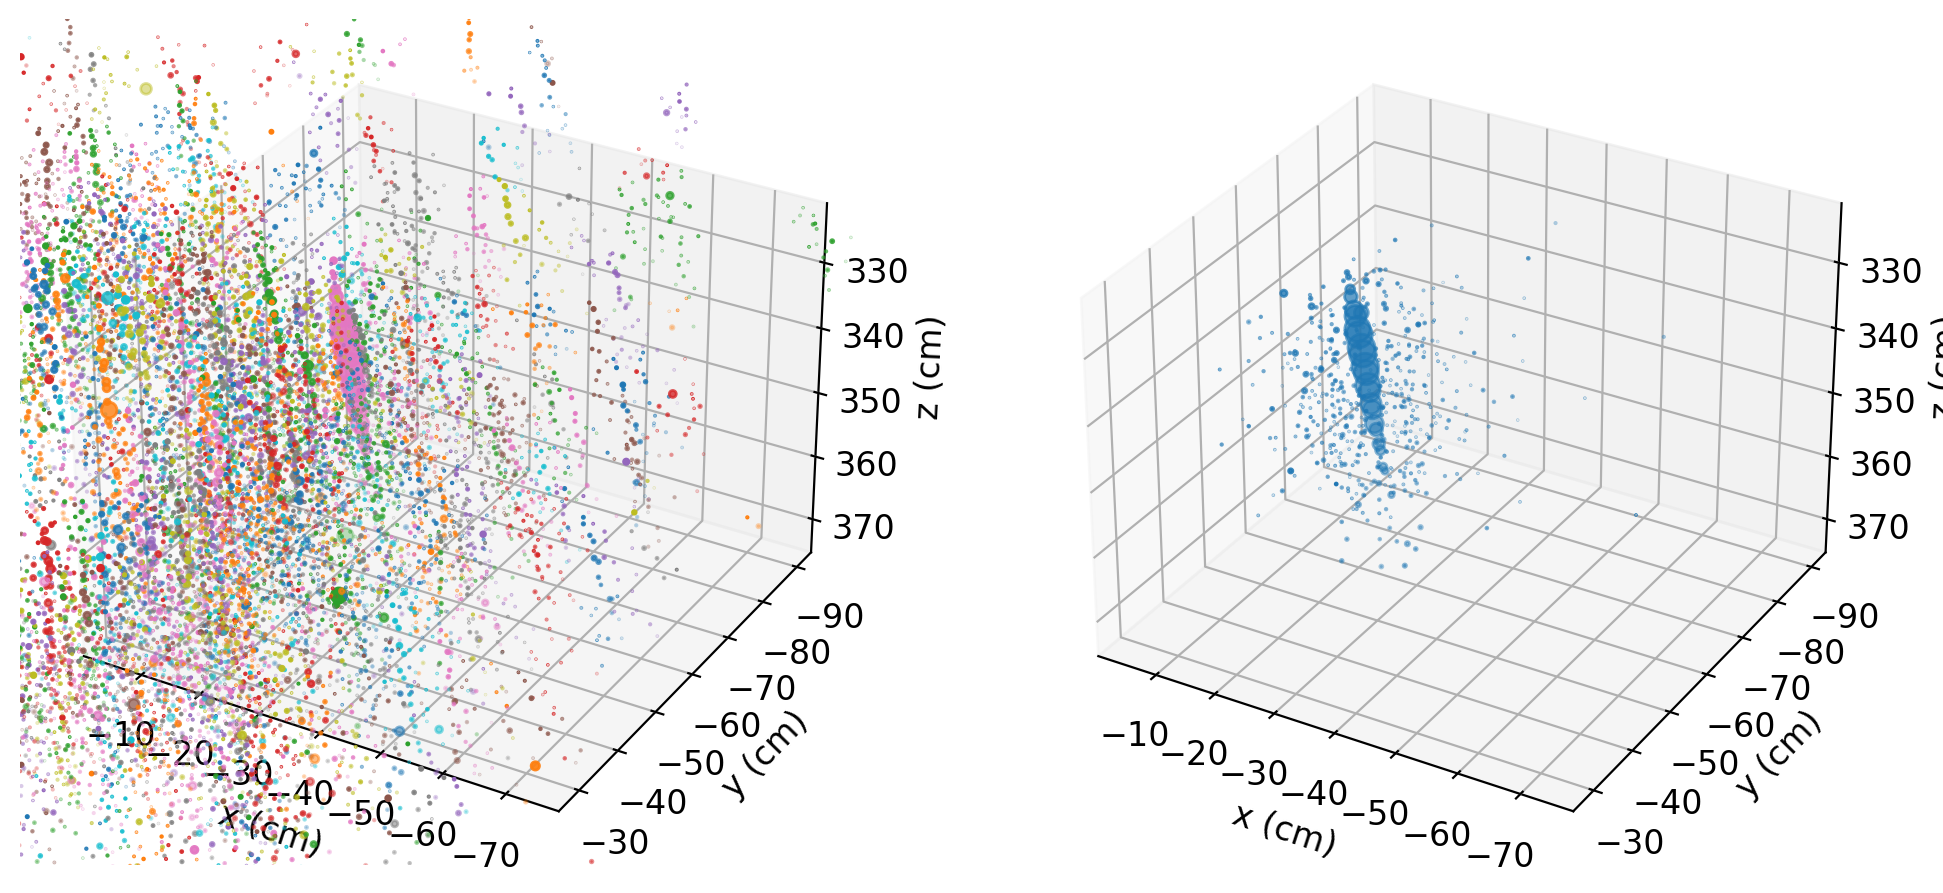

In [4]:
eid = 9
reco2sim_index = assoc_data["tsCLUE3D_recoToSim_SC"][eid]
reco2sim_sharedE = assoc_data["tsCLUE3D_recoToSim_SC_sharedE"][eid]
raw_energy = trackster_data["raw_energy"][eid]

shareE = []

for recoT_idx, (sim_indexes, shared_energies) in enumerate(zip(reco2sim_index, reco2sim_sharedE)):
    for simT_idx, shared_energy in zip(sim_indexes, shared_energies):
        # 2 goals here:
        # - find the trackster with >50% shared energy
        # - find the tracksters with < 0.2 score
        # if score > score_threshold: continue

        st_energy = raw_energy[recoT_idx]
        st_fraction = shared_energy / st_energy

        if st_fraction > 0.1:
            shareE.append(recoT_idx)

print(shareE)

vi = trackster_data["vertices_indexes"][eid] # [shareE]
vertices_x, vertices_y, vertices_z, vertices_e = clusters_by_indices(cluster_data, vi, eid)

svi = simtrackster_data["stsSC_vertices_indexes"][eid]
st_x, st_y, st_z, st_e = clusters_by_indices(cluster_data, svi, eid)

ax1, ax2 = plot_sim_reco(
    vertices_x,
    vertices_y,
    vertices_z,
    vertices_e,
    st_x,
    st_y,
    st_z,
    st_e,
    simtrackster_data["stsSC_vertices_indexes"][eid],
    simtrackster_data["stsSC_vertices_multiplicity"][eid],
    energy_threshold=0,
    align_dim=True,
)


In [5]:
dX, dY, _pair_index = get_event_pairs(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    eid,
    10,
    pileup=True,
)

pair_index = np.array(_pair_index)
pos_index = np.array(dY) >= 0.5
neg_index = np.array(dY) < 0.5

# for i, p in  enumerate(_pair_index):
#     print(p, dY[i])

print(sum(pos_index), sum(neg_index))
positive = pair_index[pos_index]
negative = pair_index[neg_index]

9 19


In [6]:
bigT = pair_index[0][1]
bigT

2306

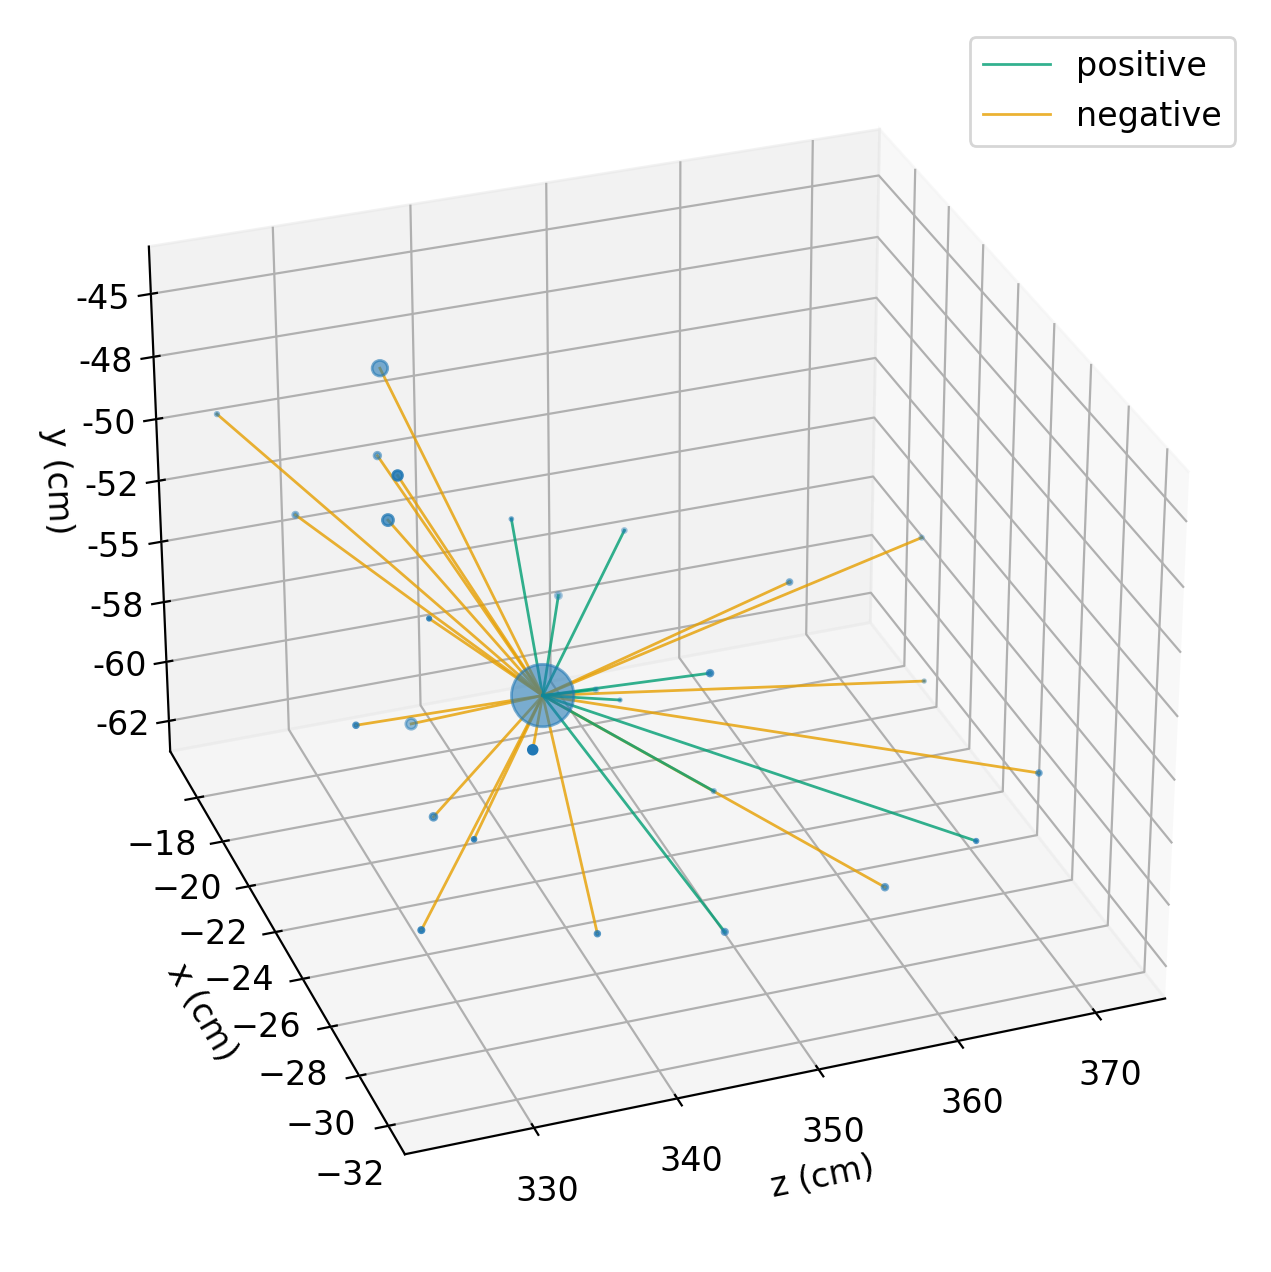

In [7]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

all_tx = list(set(ak.flatten(positive).tolist() + ak.flatten(negative).tolist()))

bary = get_bary_data(trackster_data, eid)
ax1.scatter(bary[:,2][all_tx], bary[:,0][all_tx], bary[:,1][all_tx], s=trackster_data["raw_energy"][eid][all_tx])

pos_edges = []
neg_edges = []

def plot_edge(ax, edge, color, label=None):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(z, x, y, c=color, linewidth=1, alpha=0.8, label=label) 


plot_edge(ax1, positive[0], "#009E73", "positive")
if len(negative):
    plot_edge(ax1, negative[0], "#E69F00", "negative")
    [plot_edge(ax1, edge, "#E69F00") for edge in negative[1:]]

[plot_edge(ax1, edge, "#009E73") for edge in positive[1:]]

ax1.set_xlabel("z (cm)")
ax1.set_ylabel("x (cm)")
ax1.set_zlabel("y (cm)")
ax1.view_init(elev=30, azim=-110)

ax1.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))


plt.legend()

# fig.savefig('export/two-pion-10cm-neighborhood.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [8]:
vi = trackster_data["vertices_indexes"][eid]
vertices_x, vertices_y, vertices_z, vertices_e = clusters_by_indices(cluster_data, vi, eid)

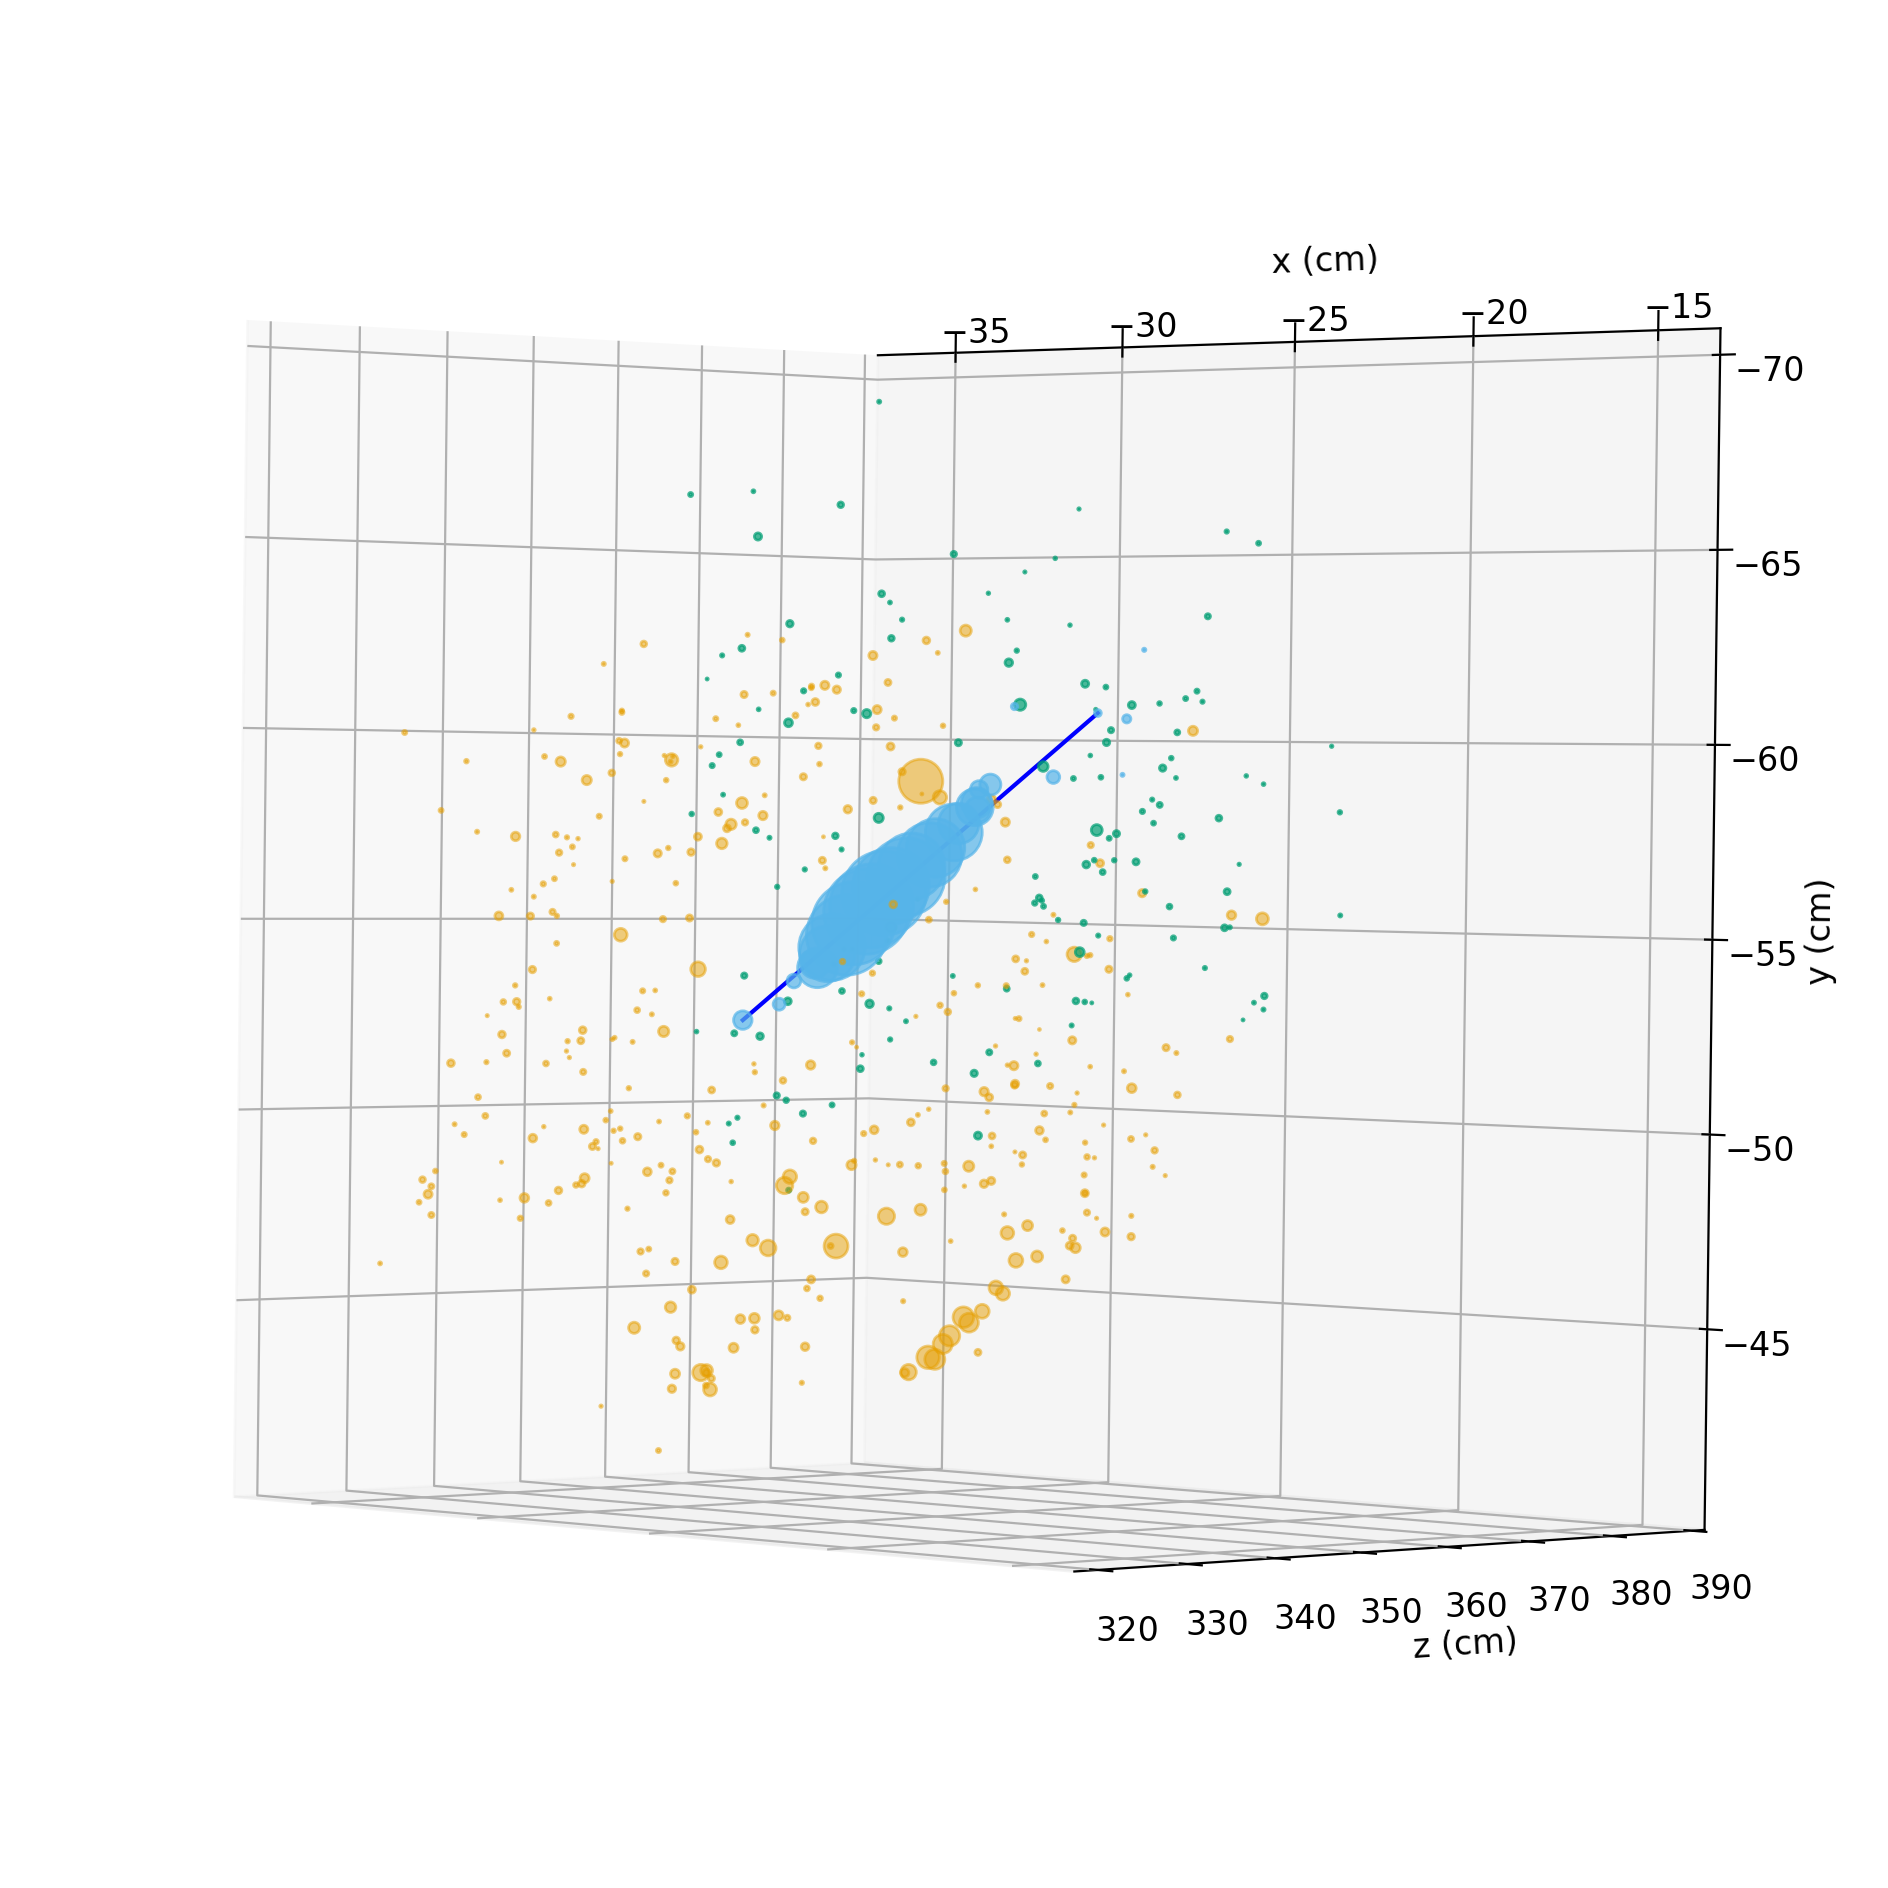

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')


# ax.set_title(f"Reconstruction of a photon in a high-pileup environment")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")

bubble_size = 20
pileup_alpha = 0.5
noise_threshold = 0.5

bve = vertices_e[bigT]
ax.scatter(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT], alpha=0.7, s=bve*bubble_size, c="#56B4E9", label=f"{len(bve)} LC: {sum(bve):.2f} GeV")
minp, maxp = get_min_max_z_points(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT])

ax.plot(
    (minp[0], maxp[0]),
    (minp[1], maxp[1]),
    (minp[2], maxp[2]),
    c="blue"
)

for (recoTxId, _), label in zip(pair_index, dY):
    vxr = vertices_x[recoTxId]
    vyr = vertices_y[recoTxId]
    vzr = vertices_z[recoTxId]

    rve = vertices_e[recoTxId]
    clr = "#009E73" if label > noise_threshold else "#E69F00"
    alpha = 0.7 if label > noise_threshold else pileup_alpha
    ax.scatter(vxr, vyr, vzr, s=rve*bubble_size, c=clr, label=f"{len(rve)} LC: {sum(rve):.2f} GeV", alpha=alpha)
    # ax.plot(
    #     (minp[0], maxp[0]),
    #     (minp[1], maxp[1]),
    #     (minp[2], maxp[2]),
    #     c=clr
    # )

ax.view_init(-45, -1, -90)
# plt.legend()
# fig.savefig('export/photon-endcap-with-PU.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Evaluation

In [10]:
from reco.evaluation import evaluate
import awkward as ak
from reco.plotting import plot_sim_reco
nhits = cluster_data["cluster_number_of_hits"][eid]

t_indices = vi[bigT:bigT+1]
t_mlc_index = ak.Array([nhits[t] > 0 for t in t_indices])
t_indices = t_indices[t_mlc_index]

st_indices = simtrackster_data["stsSC_vertices_indexes"][eid]
st_mlc_index = ak.Array([nhits[t] > 0 for t in st_indices])
st_indices = st_indices[st_mlc_index]


t_multi = trackster_data["vertices_multiplicity"][eid][bigT:bigT+1][t_mlc_index]

st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indices, eid)
st_multi =  simtrackster_data["stsSC_vertices_multiplicity"][eid][st_mlc_index]

In [11]:
# other evaluation
sti = st_indices[0]
rti = t_indices[0]

_, _, _, t_energy = clusters_by_indices(cluster_data, t_indices, eid)
st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indices, eid)

print("St indices: ", len(sti), sum(t_energy[0]))
print("Reco indices: ", len(rti), sum(st_energy[0]))

St indices:  521 504.5968817770481
Reco indices:  30 602.8874474782497


In [12]:
shared_lc = np.intersect1d(sti, rti)
shared_e = cluster_data["energy"][eid][shared_lc]

print(len(shared_lc), sum(shared_e))

28 502.3169504404068


In [14]:
print(f"Baseline: reco energy {sum(t_energy[0]):.2f} GeV) | sim energy: {sum(st_energy[0]):.2f} ")
Pr, Re, F1 = evaluate(nhits, t_indices, st_indices, t_energy, st_energy, t_multi, st_multi, beta=0.5)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

Baseline: reco energy 504.60 GeV) | sim energy: 602.89 
	Precision: 0.97 | Recall: 0.91 | F1: 0.96


In [15]:
# after connecting the trackster
# create the merge map using the label
selected_t_indexes = [i for i, _ in positive]
selected_t_indexes.append(bigT)

r_indices = ak.Array([ak.flatten(vi[selected_t_indexes])])
r_multi = ak.Array([ak.flatten(trackster_data["vertices_multiplicity"][eid][selected_t_indexes])])
r_x, r_y, r_z, r_energy = clusters_by_indices(cluster_data, r_indices, eid)

print("Reco tracksters:", len(r_indices), "Sim tracksters:", len(st_indices))

Reco tracksters: 1 Sim tracksters: 1


In [16]:
print(f"After connection (energy {sum(r_energy[0]):.2f} GeV):")
Pr, Re, F1 = evaluate(nhits, r_indices, st_indices, r_energy, st_energy, r_multi, st_multi)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

After connection (energy 526.94 GeV):
	Precision: 0.97 | Recall: 0.95 | F1: 0.97


In [17]:
print(len(r_indices[0]))
print(len(rti))

173
30


In [18]:
shared_lc = np.intersect1d(st_indices, r_indices)
shared_e = cluster_data["energy"][eid][shared_lc]

print(len(shared_lc), sum(shared_e))

155 522.8913274183869


Text(0.5, 0.92, 'Improved reco trackster')

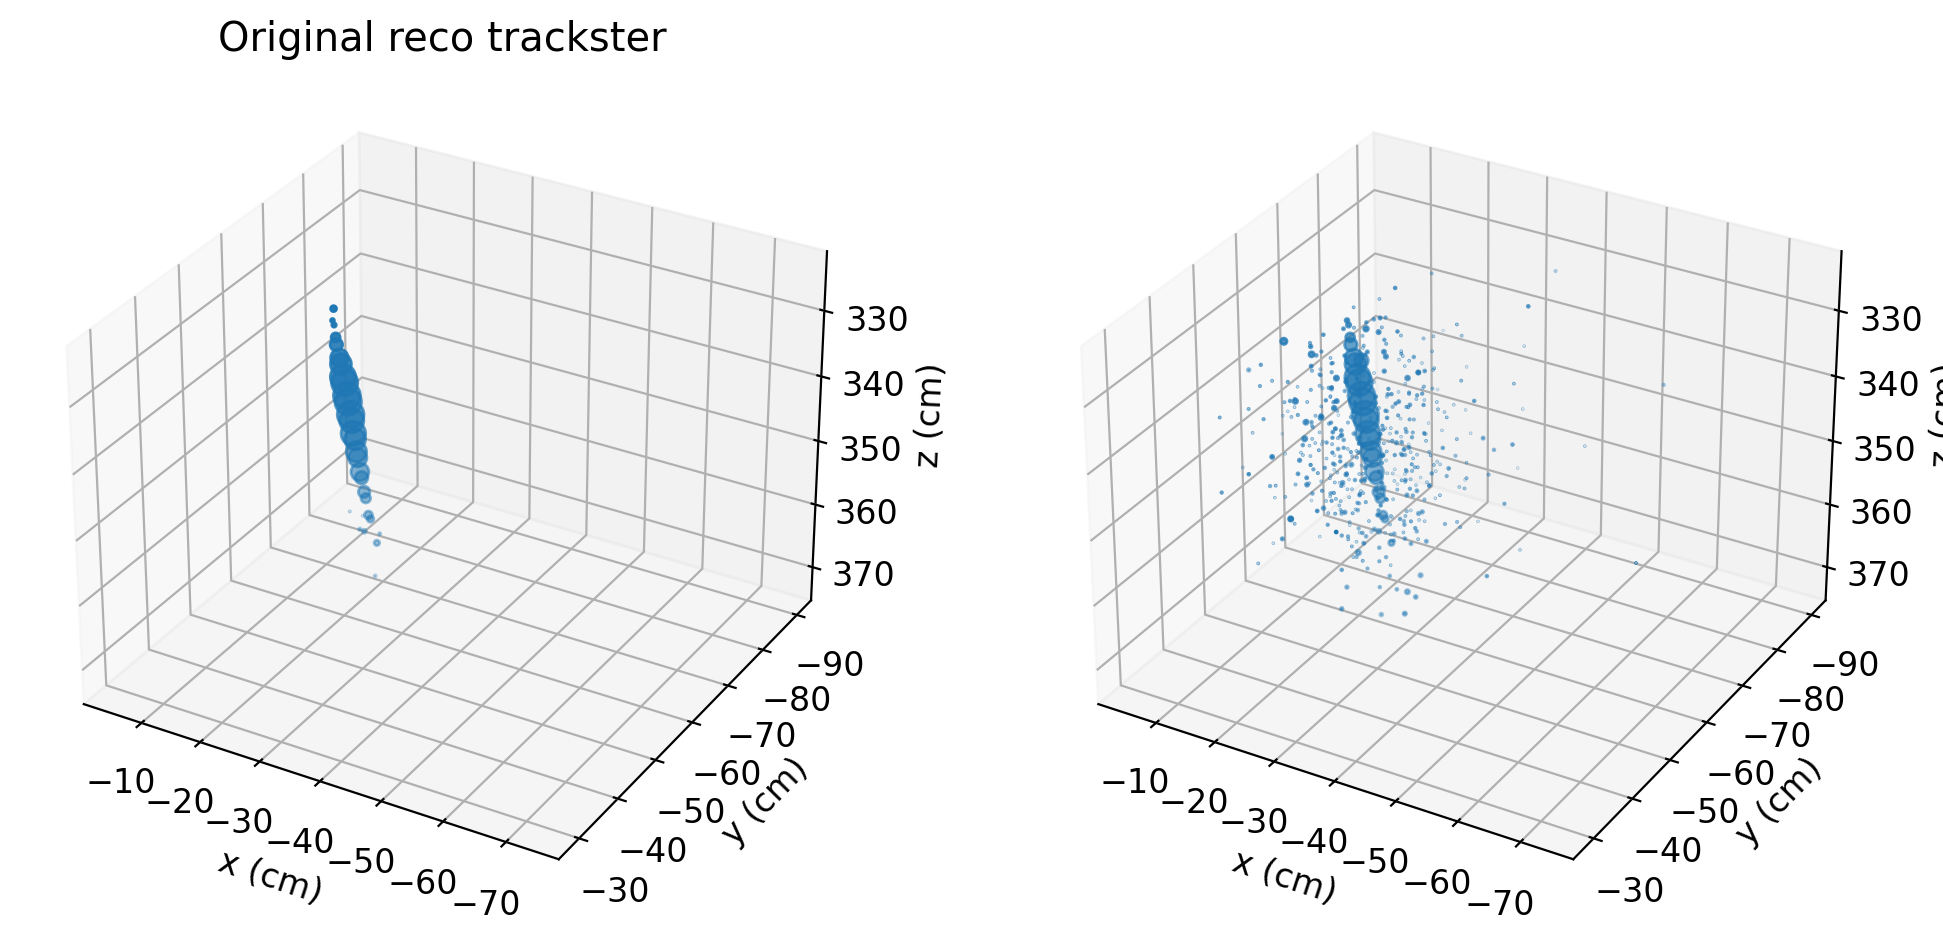

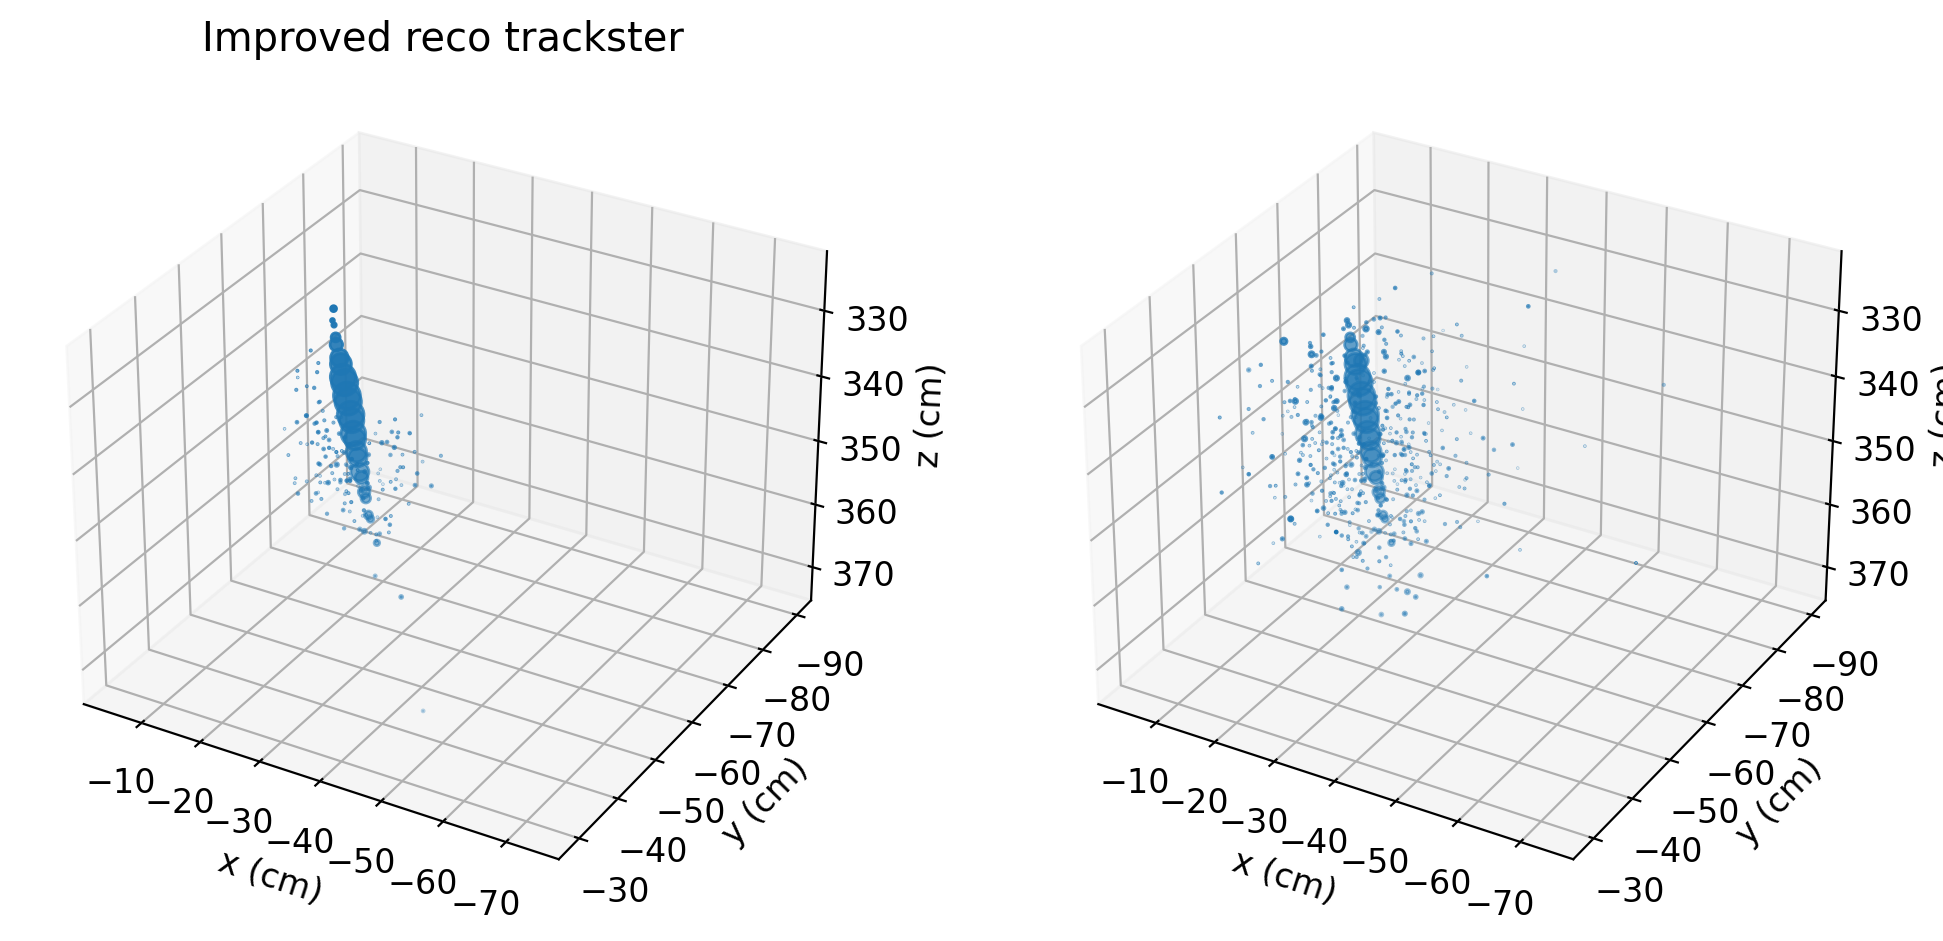

In [59]:
ax1, ax2 = plot_sim_reco(
    vertices_x[bigT:bigT+1],
    vertices_y[bigT:bigT+1],
    vertices_z[bigT:bigT+1],
    vertices_e[bigT:bigT+1],
    st_x,
    st_y,
    st_z,
    st_energy,
    simtrackster_data["stsSC_vertices_indexes"][eid],
    simtrackster_data["stsSC_vertices_multiplicity"][eid],
    energy_threshold=0
)

ax1.set_title("Original reco trackster")

ax1, ax2 = plot_sim_reco(
    r_x,
    r_y,
    r_z,
    r_energy,
    st_x,
    st_y,
    st_z,
    st_energy,
    simtrackster_data["stsSC_vertices_indexes"][eid],
    simtrackster_data["stsSC_vertices_multiplicity"][eid],
    energy_threshold=0
)

ax1.set_title("Improved reco trackster")

## Feature sensitivity analysis

In [51]:
from reco.datasetPU import TracksterPairs

ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=5,
    radius=30,
    pileup=True
)
ds

<TracksterPairs len=14080 radius=30 score_threshold=0.2 bigT_e_th=40>

In [52]:
ds.x.shape

torch.Size([14080, 47])

In [53]:
from matplotlib.ticker import FormatStrFormatter
from reco.dataset import FEATURE_KEYS

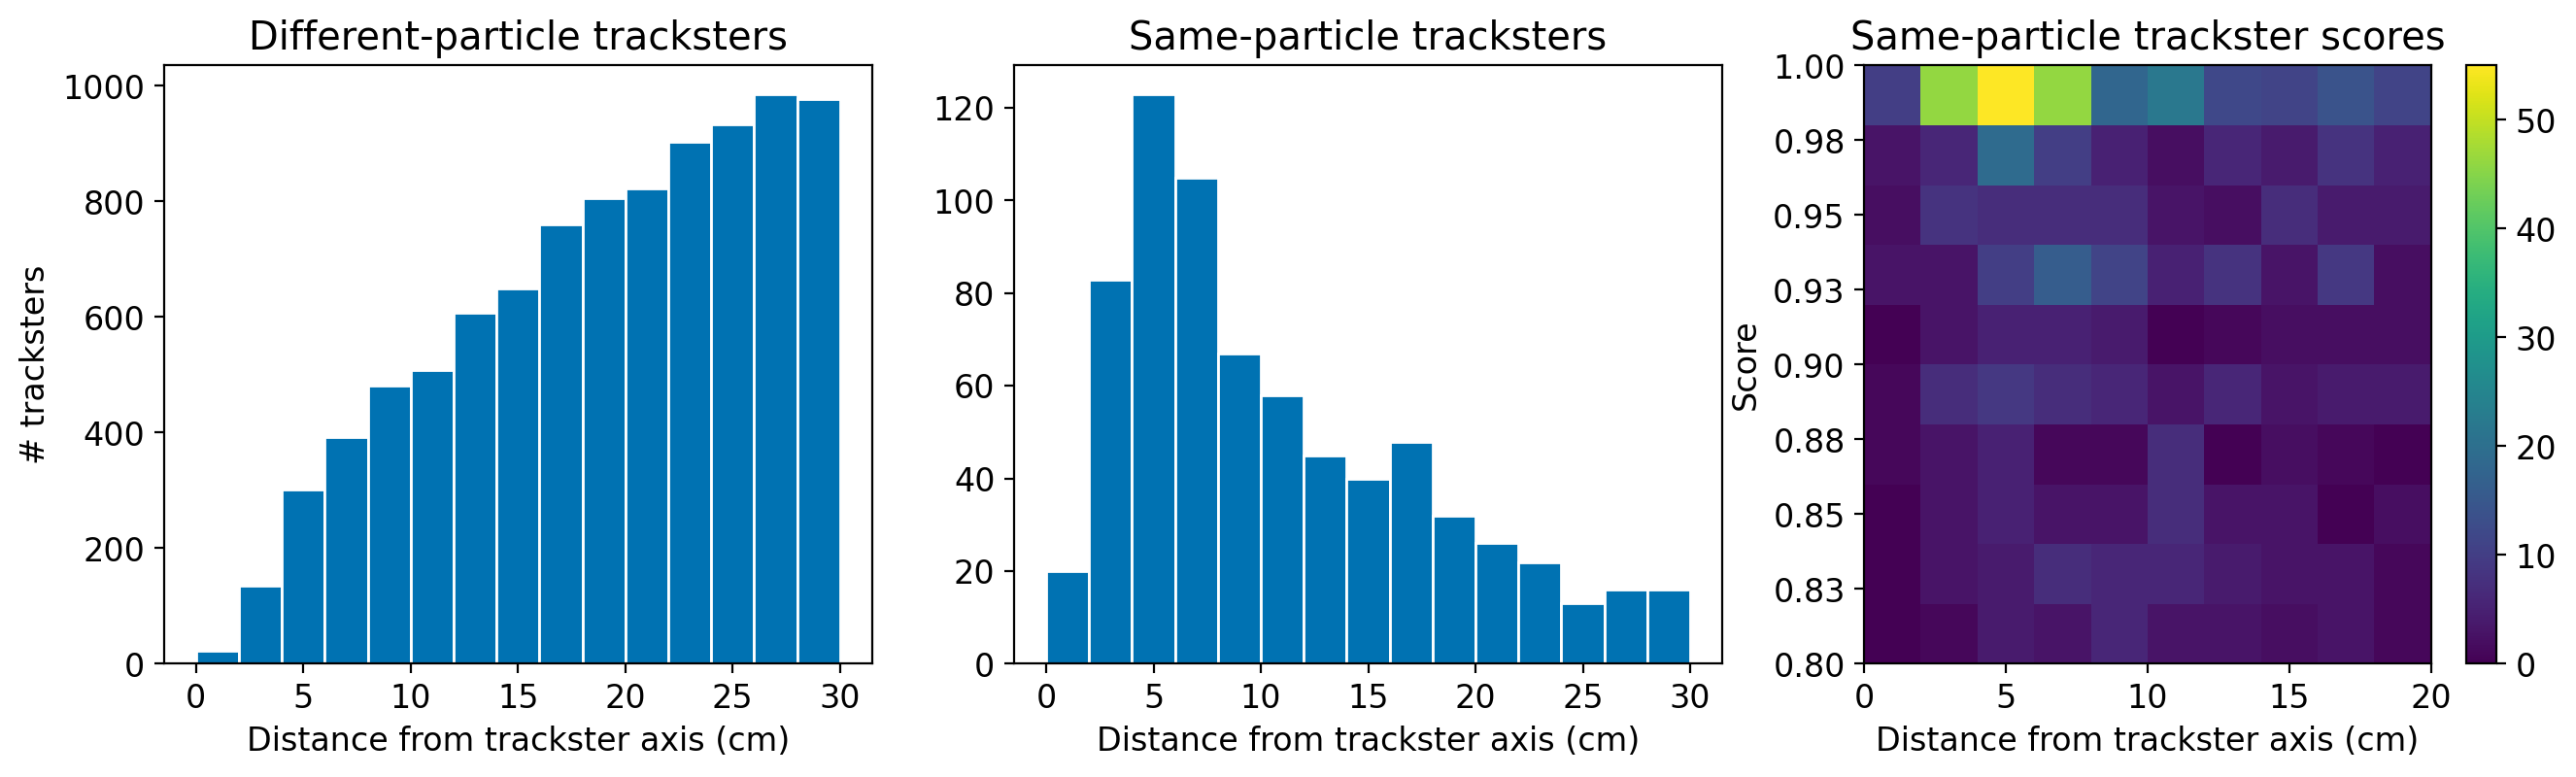

In [59]:
# distance, num-LC big, num-LC small
m = ds.x[:10000,-3:]
positive_idx = ds.y[:10000] >= 0.8
negative_idx = ds.y[:10000] < 0.8

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# ax1 = fig.add_subplot(111)

ax1.hist(m[:,0][negative_idx], edgecolor="white", color="#0072B2", bins=15, range=(0, 30))
ax1.set_title("Different-particle tracksters")
ax1.set_xlabel("Distance from trackster axis (cm)")
ax1.set_ylabel("# tracksters")

ax2.hist(m[:,0][positive_idx], edgecolor="white", color="#0072B2", bins=15, range=(0, 30))
ax2.set_title("Same-particle tracksters")
ax2.set_xlabel("Distance from trackster axis (cm)")

im = ax3.hist2d(np.array(m[:,0][positive_idx]), np.array(ds.y[:10000][positive_idx]), range=((0, 20), (0.8, 1)))
ax3.set_title("Same-particle trackster scores")
ax3.set_xlabel("Distance from trackster axis (cm)")
ax3.set_ylabel("Score")
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.colorbar(im[3], ax=ax3)


# plt.hist(m[:,0][negative_idx], edgecolor="lightblue")
# plt.title("Negative edges")
# plt.xlabel("Planear distance in CM")
fig.savefig('export/pion-PU200-10k-trackster-distances.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

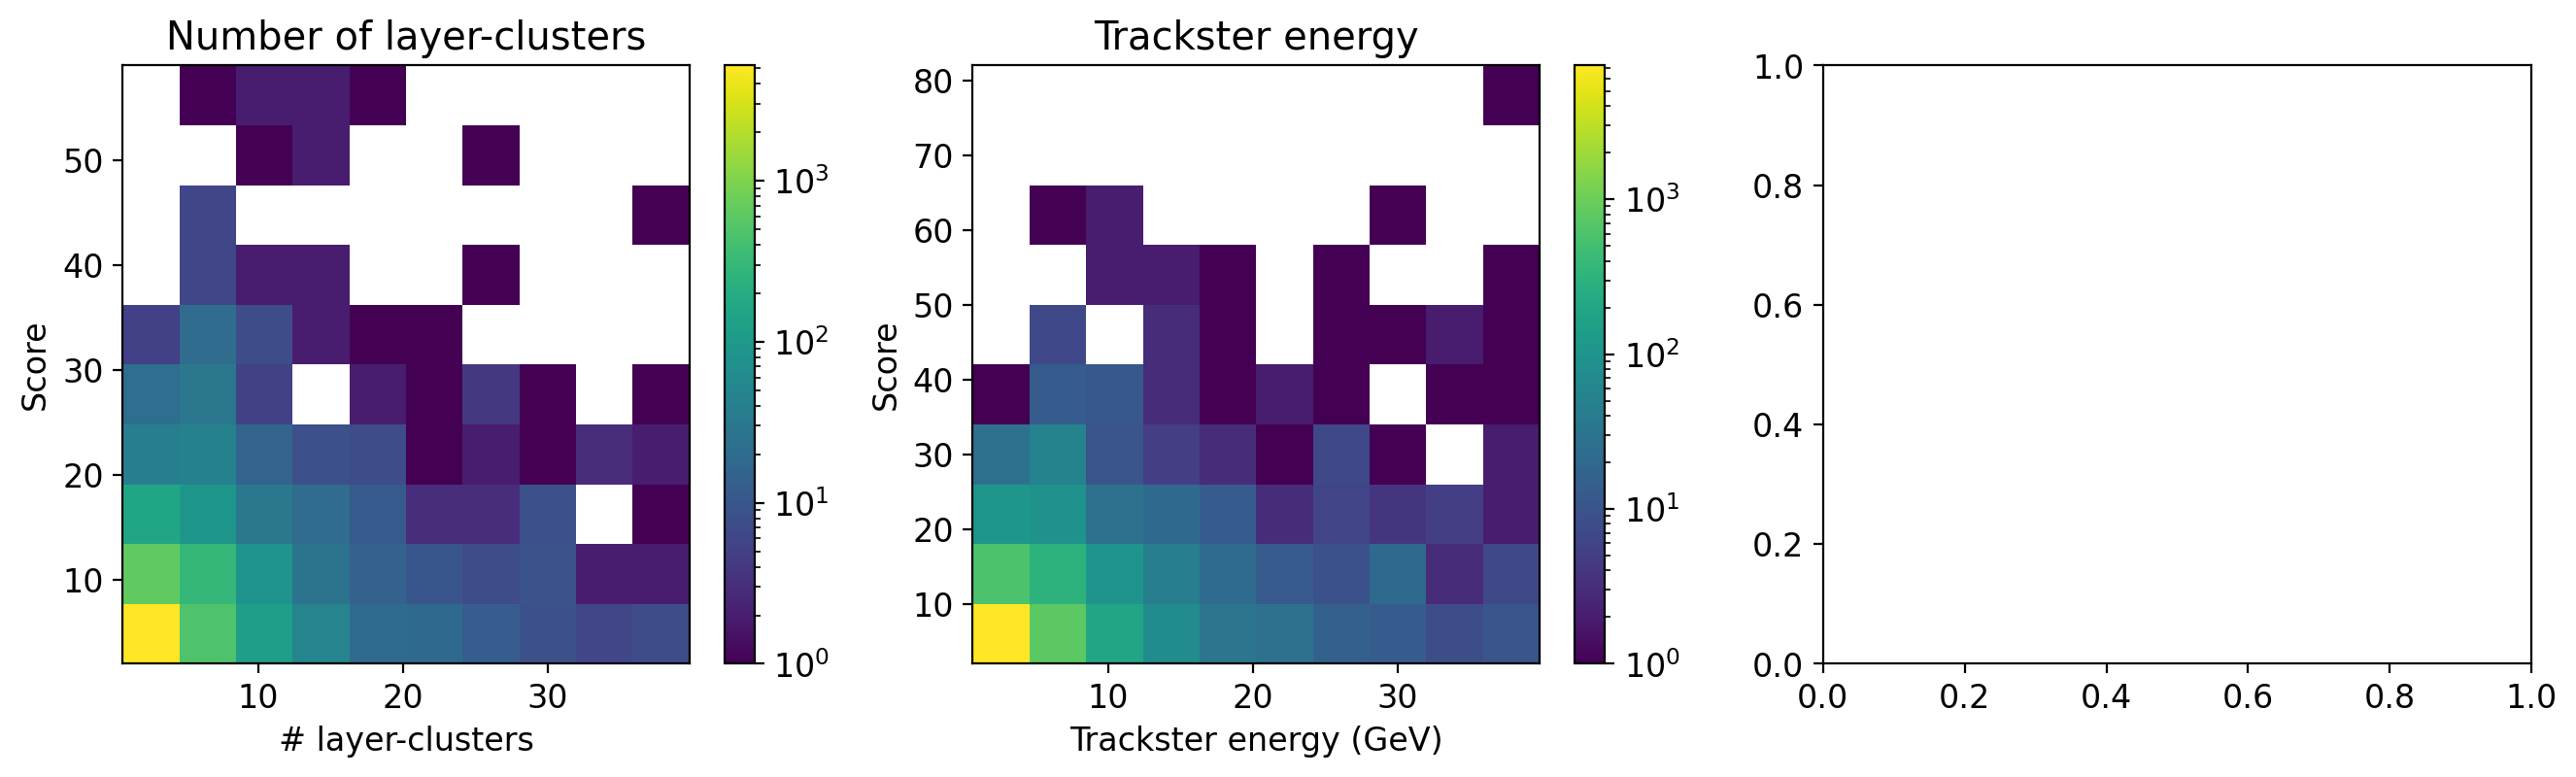

In [58]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

re_idx = 5 + len(FEATURE_KEYS)
im1 = ax1.hist2d(np.array(ds.x[:10000, re_idx][positive_idx]), np.array(m[:,2])[positive_idx], norm="log")
ax1.set_title("Number of layer-clusters")
ax1.set_xlabel("# layer-clusters")
ax1.set_ylabel("Score")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.colorbar(im1[3], ax=ax1)

im2 = ax2.hist2d(np.array(ds.x[:10000, re_idx]), np.array(m[:,2]), norm="log")
ax2.set_title("Trackster energy")
ax2.set_xlabel("Trackster energy (GeV)")
ax2.set_ylabel("Score")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.colorbar(im2[3], ax=ax2)


plt.show()

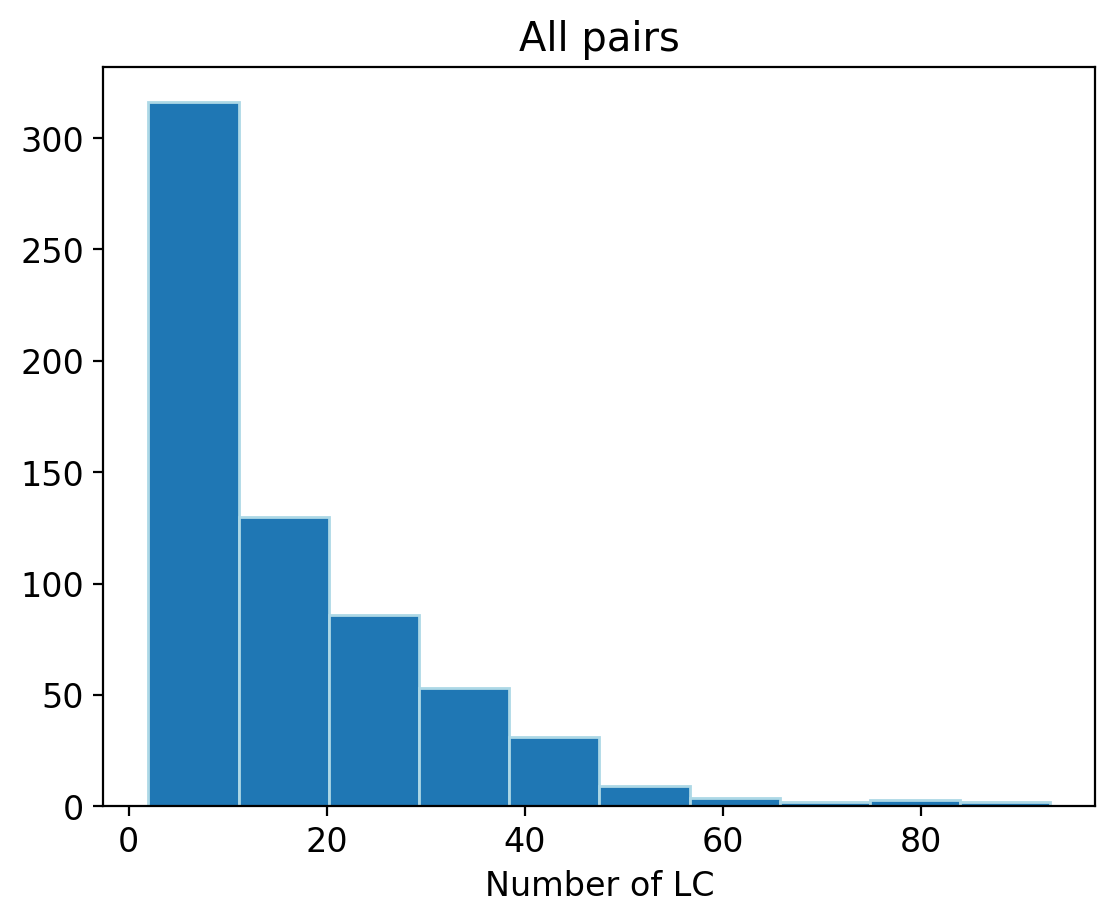

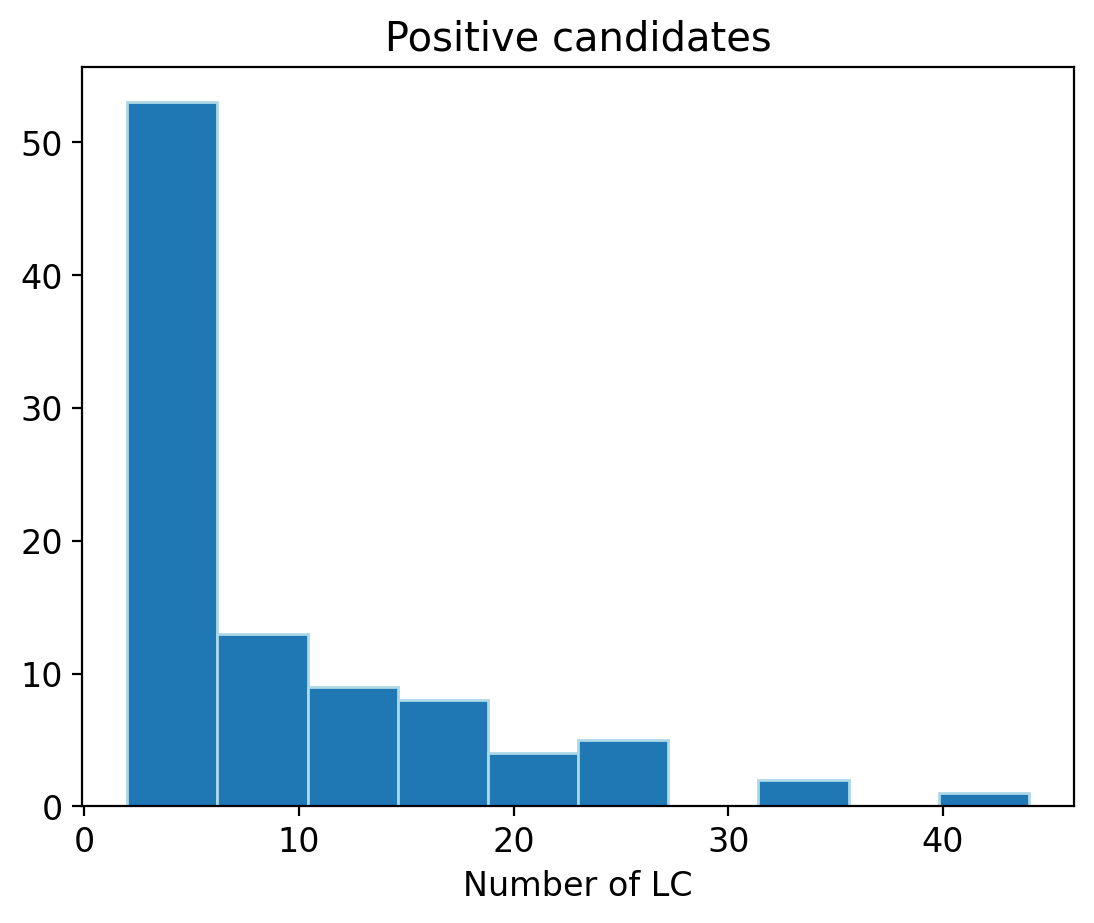

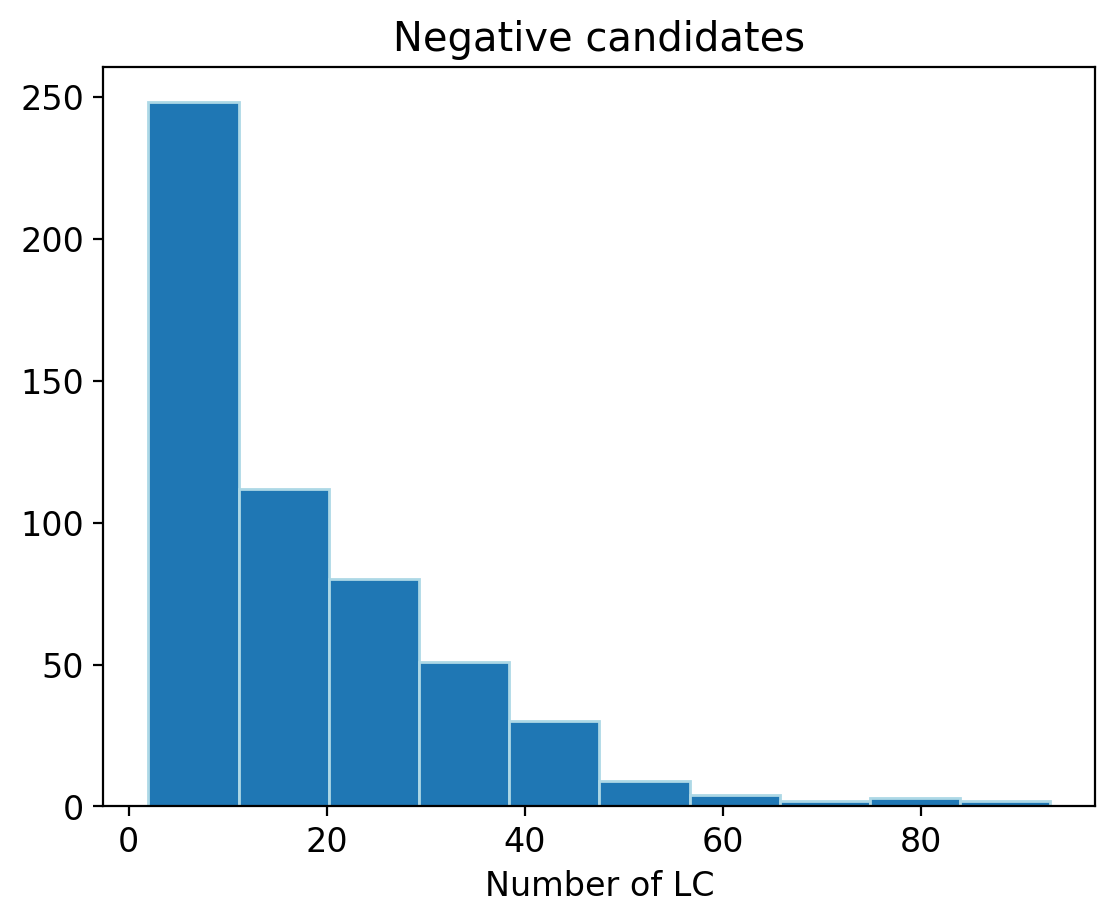

In [6]:
plt.hist(m[:,2], edgecolor="lightblue")
plt.title("All pairs")
plt.xlabel("Number of LC")
plt.show()

plt.hist(m[:,2][positive_idx], edgecolor="lightblue")
plt.title("Positive candidates")
plt.xlabel("Number of LC")
plt.show()


plt.hist(m[:,2][negative_idx], edgecolor="lightblue")
plt.title("Negative candidates")
plt.xlabel("Number of LC")
plt.show()

# --> no difference

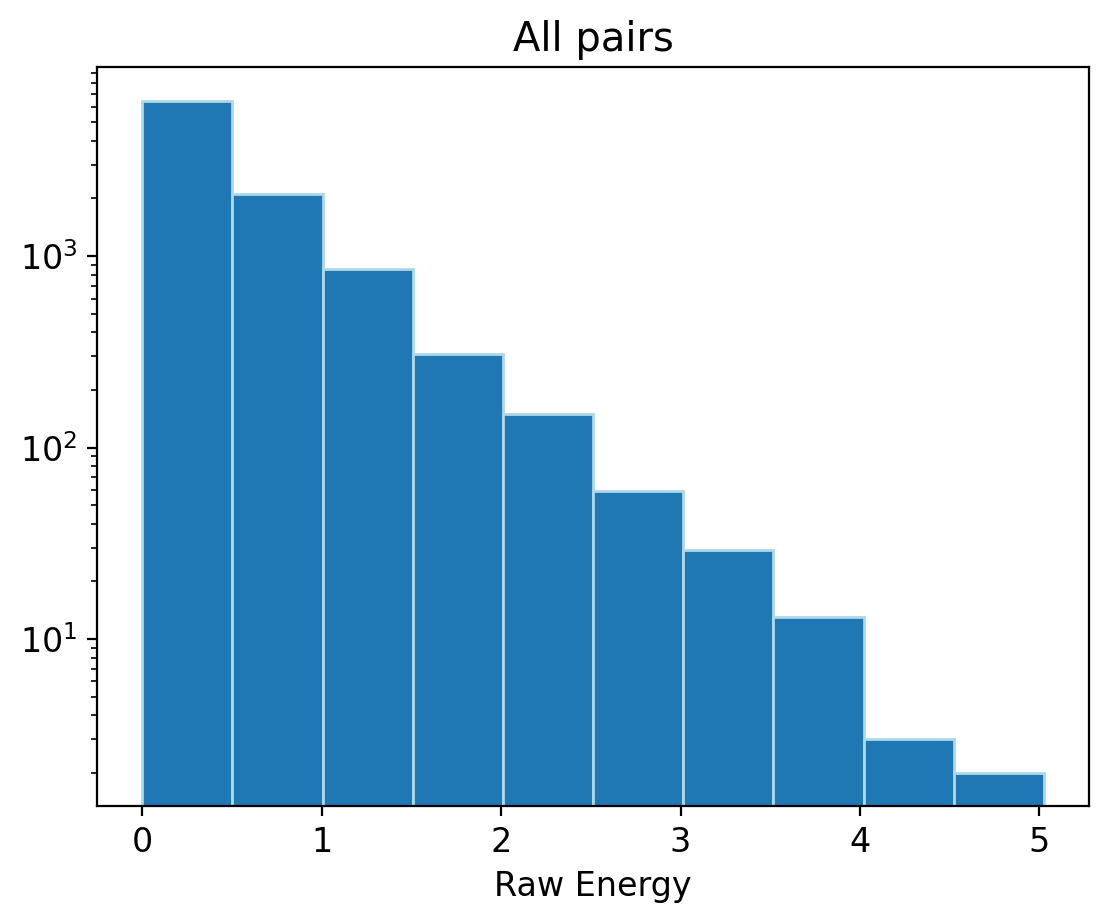

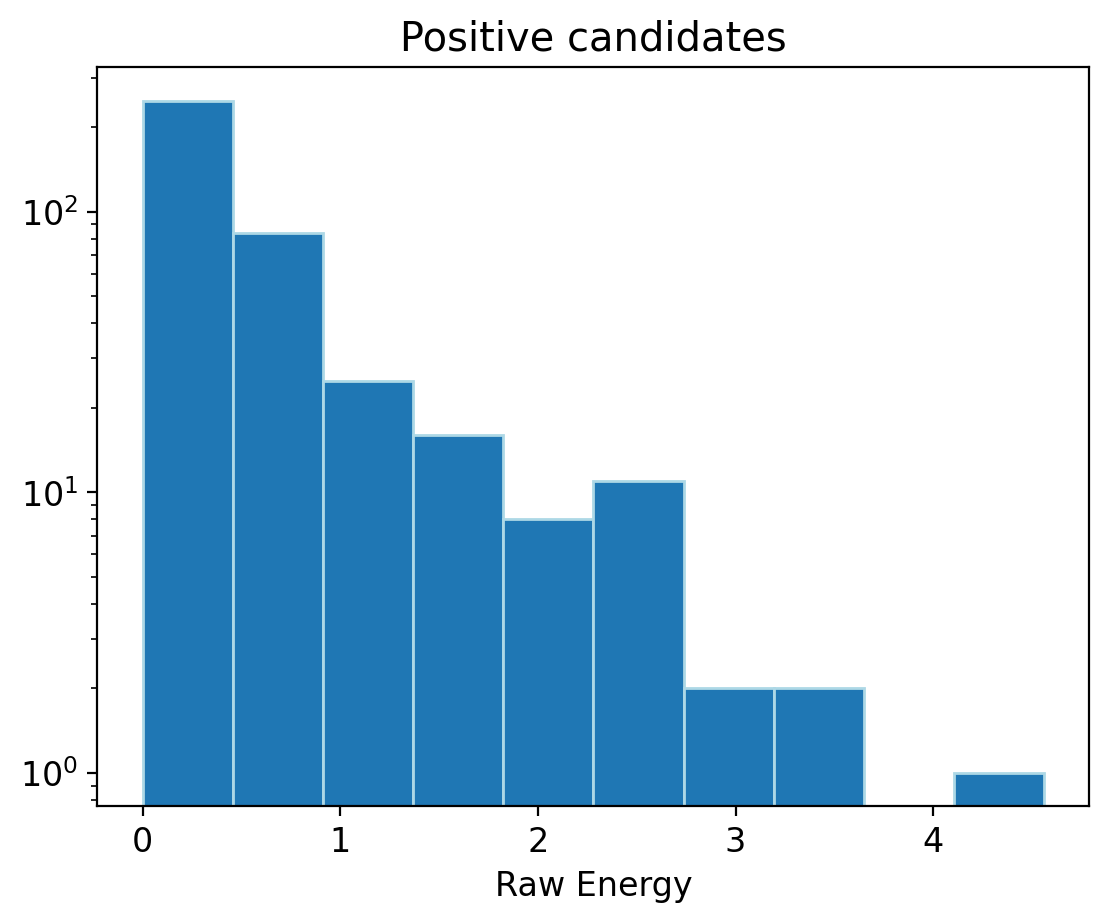

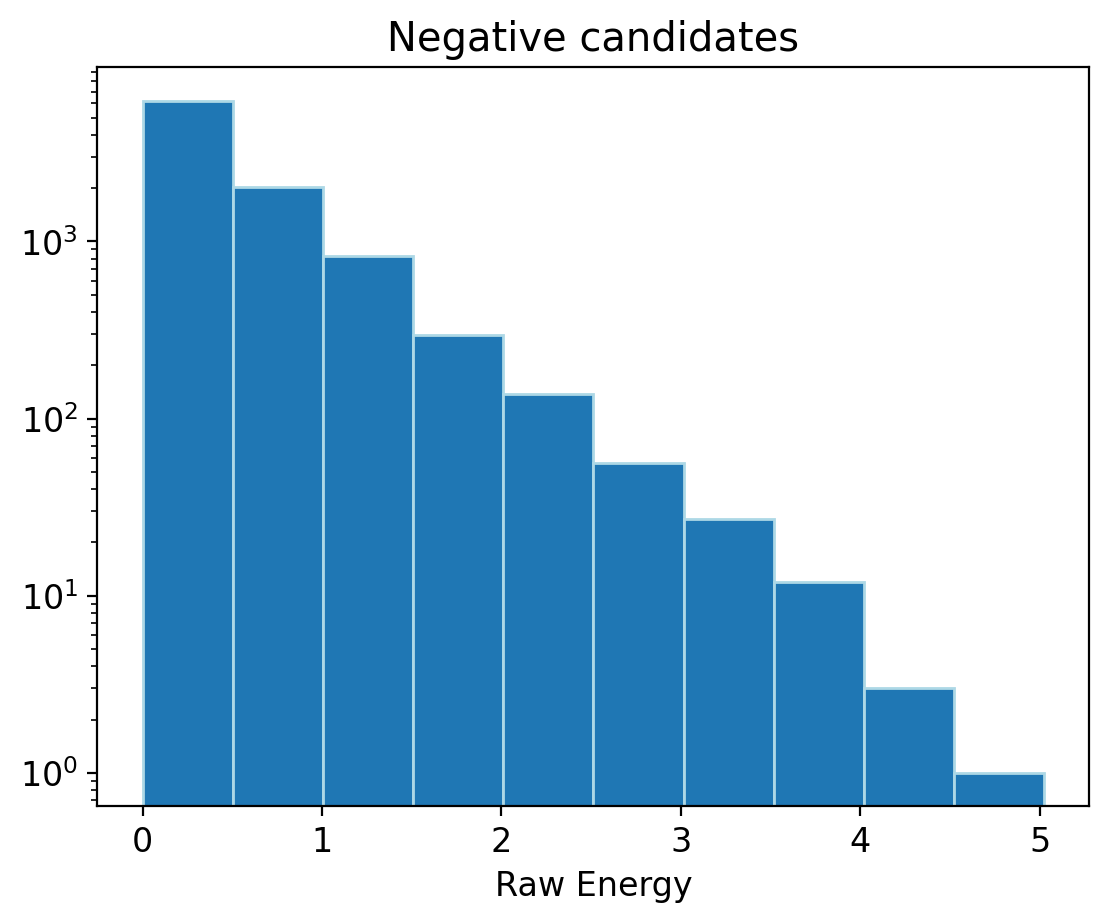

In [99]:

# features of the big trackster
nfeat = len(FEATURE_KEYS)

# index of the feature of interest
f_index = 5 + len(FEATURE_KEYS)

plt.hist(ds.x[:10000, f_index], edgecolor="lightblue")
plt.yscale("log")
plt.title("All pairs")
plt.xlabel("Raw Energy")
plt.show()

plt.hist(ds.x[:10000, f_index][positive_idx], edgecolor="lightblue")
plt.yscale("log")
plt.title("Positive candidates")
plt.xlabel("Raw Energy")
plt.show()

plt.hist(ds.x[:10000, f_index][negative_idx], edgecolor="lightblue")
plt.yscale("log")
plt.title("Negative candidates")
plt.xlabel("Raw Energy")
plt.show()

# --> can't really tell